In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from scipy.stats.stats import pearsonr

# Load the full scan

In [3]:
fc = FileChooser('/sf/alvra/data/p18442/res/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18442/res/scan_info', filename='', show_hidden='False')

In [10]:
Timezero = 175.70976 # position of Timezero on PP delay (in mm!)

quantile_corr = 0.5

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_delay_harm]

####################################################################################################3

from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Delay_mm = scan.readbacks

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
        
    IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
    IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
    DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
    DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump
    
    DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
    DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
    Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
    
    df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
    df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
    df_pump_probe = pd.DataFrame(Pump_probe_shot)
          
    DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)

Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

Step 51 of 51: Processing run_001446

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet    1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET   1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY  1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS 1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1999 / 1999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 500 pump and 500 unpump shots
Job done!
Quantiles for error bars: 0.25,0.75


<IPython.core.display.Javascript object>


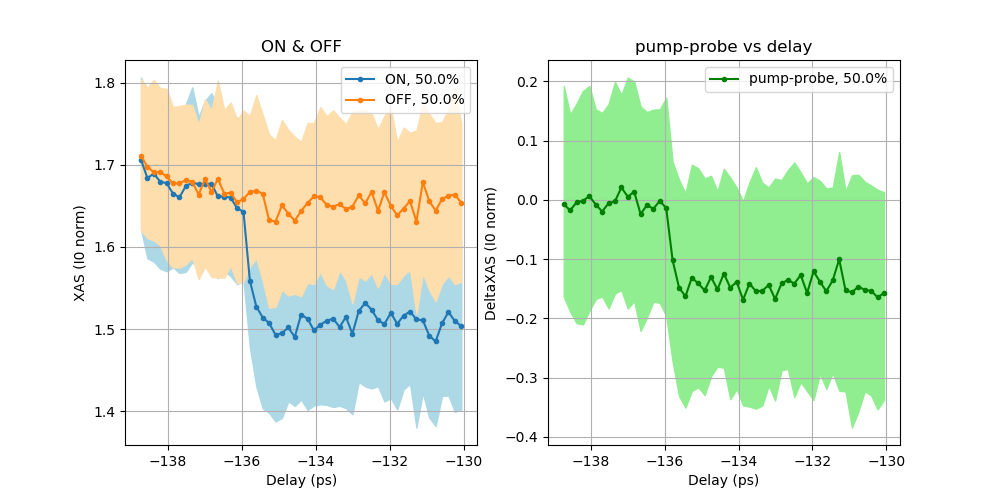

t0 = 175.70976 mm


In [11]:
plt.figure(figsize = (10,5))
plt.suptitle(fc.selected.split('/')[-1], fontsize =12)

Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
pump = DataFluo_pump[:,0]
err_low_pump = DataFluo_pump[:,1]
err_high_pump = DataFluo_pump[:,2]
unpump = DataFluo_unpump[:,0]
err_low_unpump = DataFluo_unpump[:,1]
err_high_unpump = DataFluo_unpump[:,2]
pump_probe = Pump_probe[:,0]
err_low_pump_probe = Pump_probe[:,1]
err_high_pump_probe = Pump_probe[:,2]

plt.subplot(1,2,1)
plt.plot(Delay_ps, pump, label='ON, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Delay_ps, err_low_pump, err_high_pump, color='lightblue')

plt.plot(Delay_ps, unpump, label='OFF, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Delay_ps, err_low_unpump, err_high_unpump, color='navajowhite')

plt.xlabel("Delay (ps)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('ON & OFF')
plt.legend(loc="best")
plt.grid()

plt.subplot(1,2,2)
plt.plot(Delay_ps, pump_probe, label='pump-probe, {}%'.format(quantile_corr*100),color='green', marker='.')
plt.fill_between(Delay_ps,err_low_pump_probe, err_high_pump_probe, color='lightgreen')
plt.xlabel("Delay (ps)")
plt.ylabel ("DeltaXAS (I0 norm)")
plt.gca().set_title('pump-probe vs delay')
plt.legend(loc="best")
plt.grid()

plt.show()
print ('t0 = {} mm'.format(Timezero))

# Now with TT (PSEN) jitter correction

In [28]:
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from scipy.special import erf

lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)
#filter = np.concatenate((np.ones(5), 1-signal.tukey(65), np.ones(1430), np.zeros(1500)))
filter = np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047)))
filter3 = np.concatenate((np.zeros(100), np.ones(100)))
pixelNum = np.arange(0,2047)

#######################################################################################################3

background_from_fit = np.loadtxt('/sf/alvra/data/p18386/scratch/2020-10-20-10:45-psen-background.txt')

px2fs = 1.993008440575784      # new spectrometer, it is ~ 2 px to fs
p0 = 1024

In [29]:
quantile_corr = 0.5
Timezero = 175.70976

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122, channel_delay_topas,
                   channel_PSEN_signal, channel_PSEN_bkg]
channel_list_all = channel_list_pp

########################################################################
import itertools
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Delay_mm = scan.readbacks

run_number = []
Delays_stage = []
Delay_fs_stage = []
edgePos = []
edgePosRun = []
Pump_probe_all = []
Pump_probe = []
sigtraces = []
peaktraces = []

for i, step in enumerate(scan):
    clear_output(wait=True)
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), scan.files[i]))
    
    resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
    
    IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
    IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
    DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
    DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump
    
    sig = resultsPP[channel_PSEN_signal].pump
    back = resultsPP[channel_PSEN_bkg].pump
    delay_shot = resultsPP[channel_delay_topas].pump
    
    delay_shot_fs = (delay_shot - Timezero)*2/(3e8*1e3*1e-15)
    Delay_fs_stage.append(delay_shot_fs.mean())
    
    DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
    DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
    Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
    
    Pump_probe_all.append(Pump_probe_shot)
    df_pump_probe = pd.DataFrame(Pump_probe_shot)
    Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    
    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit

        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)

        sig4inter = interp1d(nus_new, sig4invreal[0:2047], kind='cubic')
        sig5 = sig4inter(nus)
        sig5gaussO0 = gaussian_filter1d(sig5, 50)
        sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1)
        sig6 = np.roll(convolve1d(sig5gaussO0,filter3), -100)

        peak2 = np.argmax(sig5gaussO1)

        #if (peakxcorr > 0) & (peak2.max() > 0.05): 
        edgePos.append(peak2)
        Delays_stage.append(np.round(np.mean(delay_shot_fs),4))
        sigtraces.append(sig6)
        peaktraces.append(sig5gaussO1)
        
    edgePosRun.append(np.array(np.nanmean(edgePos)))
    
    
Pump_probe_all = list(itertools.chain.from_iterable(Pump_probe_all))

Delays_corr = Delays_stage + ((p0 - np.array(edgePos))*px2fs)

Pump_probe = np.asarray(Pump_probe)


Step 1 of 51: Processing ['/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_2/run_001396.BSREAD.h5', '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_2/run_001396.JF02T09V02.h5']

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET                    1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY                   1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS                  1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1999 / 1999 -> 0% loss
complete channels: 6 / 6 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 500 pump and 500 unpump shots


ValueError: operands could not be broadcast together with shapes (2190,) (2047,) 

In [34]:
sig.shape

(500, 2190)

In [ ]:
binsize = 10 # in fs

################################################################################################3
print (np.shape(Pump_probe_all),np.shape(Delays_corr))

#binList = np.arange(Delay_fs_stage[0], Delay_fs_stage[-1], binsize)
#xAxis = np.arange(Delay_fs_stage[0] + binsize/2, Delay_fs_stage[-1] - binsize/2, binsize)

binList = np.arange(Delays_corr[0], Delays_corr[-1], binsize)
xAxis = np.arange(Delays_corr[0] + binsize/2, Delays_corr[-1] - binsize/2, binsize)

s, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_all, statistic='mean', bins=binList)

## Load one step and check I0 filtering

In [13]:
filenumber = 31

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_delay_topas]

min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.5
########################################################################################################

from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Delay_mm = scan.readbacks

step = scan[filenumber]
print (step)
resultsPP, results, _, _= load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
step.close()

IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
threshold_fluo_pump = DataFluo_pump_shot > min_fluo
threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo

thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                   threshold_fluo_pump & threshold_fluo_unpump

DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]

DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
DataFluo_pump_shot_norm_raw = DataFluo_pump_shot_norm.copy()

med = np.median(DataFluo_unpump_shot_norm)
qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high

med = np.median(DataFluo_pump_shot_norm)
qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high

correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                    condition_corr_pump_low & condition_corr_pump_high

DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]

print ("Original size (pump/umpump):", len(DataFluo_pump_shot_raw), len(DataFluo_unpump_shot_raw))
print ("Filtered size conditions (pump/unpump):", len(DataFluo_pump_shot), len(DataFluo_unpump_shot))
print ("Filtered size correlation (pump/unpump):", len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm))
print ("Delay = {} mm".format(Delay_mm[filenumber]))
print ("Median value Izero (filter) = {}".format(np.median(IzeroFEL_pump_shot)))
print ("Median value fluo (filter) = {}".format(np.median(DataFluo_pump_shot_raw)))


Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18442/res/JF_pedestals/pedestal_20200131_2048.JF02T09V02.res.h5
jungfrau file: 21:59 31.01.2020
pedestal file: 20:58 31.01.2020
    mtime difference: 1:00:38.177874
SFDataFiles("/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_2/run_001427.BSREAD.h5", "/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_2/run_001427.JF02T09V02.h5"): 49 channels

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet    1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET   1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY  1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS 1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1999 / 1999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50

<IPython.core.display.Javascript object>


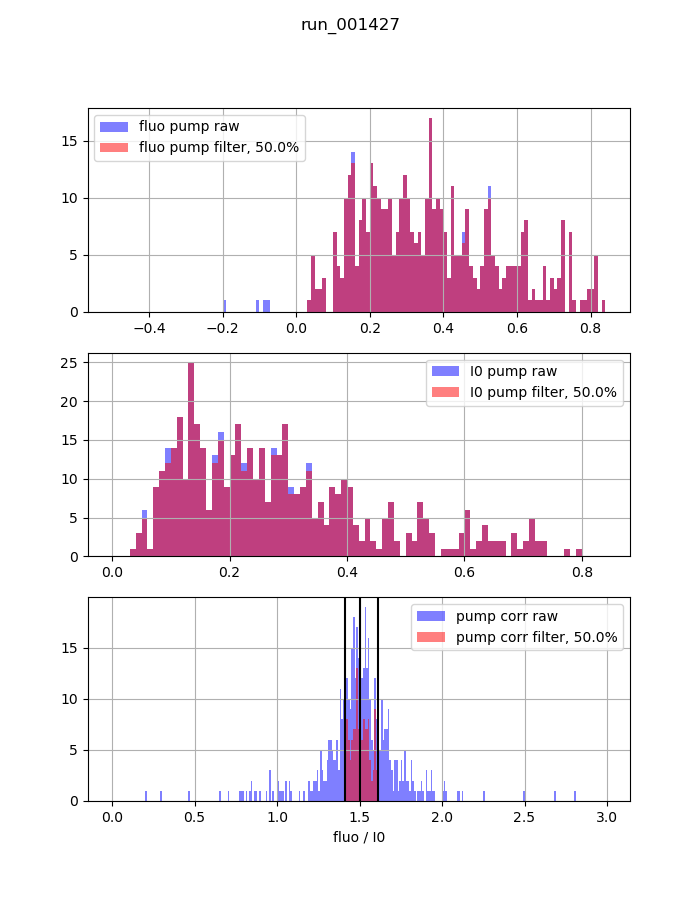

In [23]:
plt.figure(figsize = (7,9))
plt.suptitle(scan.files[filenumber][0].split('/')[-1].split('.')[0])

plt.subplot(311)
plt.hist(DataFluo_pump_shot_raw, bins =np.arange(-0.5,0.85,0.01), facecolor='blue', label="fluo pump raw", alpha=0.5)
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="fluo pump filter, {}%".format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(312)
plt.hist(IzeroFEL_pump_raw, bins =np.arange(0,0.85,0.01), facecolor='blue', label='I0 pump raw', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label ='I0 pump filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(313)
x_axis = np.arange(0,3,0.01)
plt.hist(DataFluo_pump_shot_norm_raw, bins =x_axis, facecolor='blue', label='pump corr raw', alpha=0.5)
plt.hist(DataFluo_pump_shot_norm, bins =x_axis, facecolor='red', label='pump corr filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")
plt.axvline(med, color = 'k') 
plt.axvline(qnt_low, color = 'k')
plt.axvline(qnt_high, color = 'k') 
plt.xlabel('fluo / I0')

plt.show()

#  Check data distributions with quantiles 

In [24]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

Timezero = 175.70976 # position of Timezero on PP delay (in mm!)

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_delay_harm]

####################################################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Delay_mm = scan.readbacks

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
        
    IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
    IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
    DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
    DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump
    
    DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
    DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
    Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
    
    df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
    df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
    df_pump_probe = pd.DataFrame(Pump_probe_shot)
          
    DataFluo_pump.append(np.nanquantile(df_pump, quantiles))
    DataFluo_unpump.append(np.nanquantile(df_unpump, quantiles))
    Pump_probe.append(np.nanquantile(df_pump_probe, quantiles))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)

Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

print ("Job done!")

Step 51 of 51: Processing run_001446

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet    1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET   1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY  1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS 1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1999 / 1999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 500 pump and 500 unpump shots
Job done!


<IPython.core.display.Javascript object>


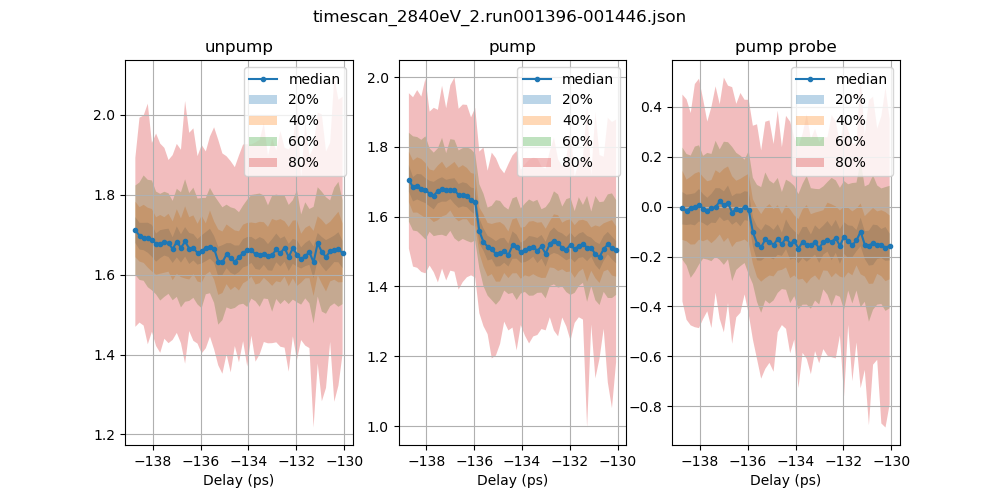

In [25]:
plt.figure(figsize = (10,5))
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

plt.subplot(1,3,1)
plt.plot(Delay_ps, DataFluo_unpump[:,0],label='median',marker='.' )
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,4]),np.array(DataFluo_unpump[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,3]),np.array(DataFluo_unpump[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,2]),np.array(DataFluo_unpump[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,1]),np.array(DataFluo_unpump[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('unpump')
plt.legend(loc="best")
#plt.ylabel("XAS ground state")
plt.xlabel("Delay (ps)")

plt.subplot(1,3,2)
plt.plot(Delay_ps, DataFluo_pump[:,0],label='median',marker='.' )
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,4]),np.array(DataFluo_pump[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,3]),np.array(DataFluo_pump[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,2]),np.array(DataFluo_pump[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,1]),np.array(DataFluo_pump[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('pump')
plt.legend(loc="best")
#plt.ylabel("XAS ground state")
plt.xlabel("Delay (ps)")

plt.subplot(1,3,3)
plt.plot(Delay_ps, Pump_probe[:,0],label='median',marker='.' )
plt.fill_between(Delay_ps,np.array(Pump_probe[:,4]),np.array(Pump_probe[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(Pump_probe[:,3]),np.array(Pump_probe[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(Pump_probe[:,2]),np.array(Pump_probe[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(Pump_probe[:,1]),np.array(Pump_probe[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('pump probe')
plt.legend(loc="best")
#plt.ylabel("Delta XAS")
plt.xlabel("Delay (ps)")

plt.show()

In [ ]:
import photodiag

#DIRcalib = '/sf/photo/src/PALM/calib/'
#DIRcalib = '/sf/photo/src/PALM/calib/Alvra'
DIRcalib = '/sf/alvra/data/p18442/res/PhotoDiag/scan_info/'

CalibrationFn = DIRcalib + '2020-01-31_17:42:38.palm_etof'

energyFrom =  1200
energyTo =    1500
energySteps = 2000
palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(energyFrom, energyTo, energySteps))

palm.load_etof_calib(CalibrationFn)

In [ ]:
quantile_corr = 0.5
ev2fsCalib= -18.913301646032846    # This is from THz scan_010
Timezero = 155.35                 # position of Timezero on PP delay (in mm!)
                
########################################################################


###########################################################################################
json_file = DIR_json + scan_name + scan_range + ".json"
#json_file = DIR_json + scan_name + "_scan_info.json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 3
print ("Processing",numFiles,"files")
print (json_file)

DataFluo_pump = []
DataFluo_unpump = []
Pump_probe = []
Pump_probe_all =[]
Delays_stage_mm = []
Delays_PALM_all = []
Number_Nans = 0
Number_shots = 0

for i in range(0, numFiles):
    filename = str(data['scan_files'][i][0])
    testdata = check_files_and_data(filename)

    if (testdata):# and (i!=12):
        #clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        
        # Load pump probe data:
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_stage_mm, \
         DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events2(filename, channel_delay)
        
        # Load PALM data:
        pulse_id_PALM, delays_PALM_eV, _, (input_data, lags, cross_corr, _) = palm.process_hdf5_file(filename, debug=True)
       
        # Load pump-unpump scheme:
        (reprate_light, reprate_dark), ratioLaser, ratioFEL = load_reprates_laser_pump(filename)
        
        pulse_id_PALM = pulse_id_PALM[:len(reprate_light)]
        delays_PALM_eV = delays_PALM_eV[:len(reprate_light)]
        cross_corr = cross_corr[:len(reprate_light)]
        input_data_0 = input_data['0'][:][:len(reprate_light)]
        input_data_1 = input_data['1'][:][:len(reprate_light)]
        
        delays_PALM_fs = delays_PALM_eV * ev2fsCalib
        
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        fullArraySize = int(len(delays_PALM_fs)/(ratioLaser * ratioFEL)*(sum(reprate_light)/sum(reprate_dark)))
        
        beamOK = ((np.amax(input_data_0,axis=1) > 0.03) & (np.amax(input_data_1,axis=1) > 0.03))
        #beamOK = (np.amax(input_data_0,axis=1) > 0.0)# & (delays !=0.0)
        
        delays_beamOK_light = delays_PALM_fs[beamOK & reprate_light]
        cross_corr_OK = cross_corr[beamOK & reprate_light]
        pulseID_OK = pulse_id_PALM[beamOK & reprate_light]
        refData_OK = input_data_0[beamOK & reprate_light]
        StrData_OK = input_data_1[beamOK & reprate_light]
        
        NumberOK = len(delays_beamOK_light) 
        shots2pad = fullArraySize - NumberOK
        
        try:        
            delays_beamOK_light = np.pad(delays_beamOK_light, (0, shots2pad), constant_values=np.NaN)
            Pump_probe_shot = np.pad(Pump_probe_shot, (0, len(delays_beamOK_light)-len(Pump_probe_shot)), constant_values=np.NaN)
            print ('Ratio pump/unpump is {}:1 at pump rep rate {} Hz, light shots are {}, need to pad {} shots' \
                   .format(ratioLaser-1, 100/ratioFEL, NumberOK, shots2pad))
            Number_Nans = Number_Nans + shots2pad
            Number_shots = Number_shots + NumberOK
        except:
            print ('Ratio pump/unpump is {}:1 at pump rep rate {} Hz, they are not commensurate, cannot pad. Keep {} light shots' \
                   .format(ratioLaser-1, 100/ratioFEL, NumberOK))
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        
        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        
        Delays_stage_mm.append(data['scan_readbacks'][i]) ## Delay from the json file
        Delays_PALM_all.append(delays_beamOK_light)
        
        Pump_probe_all.append(Pump_probe_shot)

DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)
Pump_probe_all = np.asarray(Pump_probe_all)
Delays_stage_mm = np.asarray(Delays_stage_mm)
Delays_PALM_all = np.asarray(Delays_PALM_all)  

Delays_stage_mm = np.asarray(Delays_stage_mm)# * 3e8 *1e3 /2        
Delays_stage_fs = (Delays_stage_mm - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !

print ("Job done! Total shots are {}, Nans are {}".format(Number_shots, Number_Nans))

In [ ]:
print (Delays_PALM_all.shape, Pump_probe_all.shape, Delays_stage_fs.shape)

In [ ]:
def CorrectJitterSignal(DelaysPALM_fs, DelaysSTAGE_fs, Signal, reBinFac, quantile_rebin):
    print (DelaysPALM_fs.shape, DelaysSTAGE_fs.shape, Signal.shape)
    #Delaystmp = DelaysRAW#*calibPALM
    CorrectedTime = DelaysSTAGE_fs + ((DelaysPALM_fs)-(np.nanmean(DelaysPALM_fs)))
    PALMSteps =  DelaysSTAGE_fs.shape[0]*reBinFac
    CorrectedTime = CorrectedTime.ravel()
    
    #binsCentre = np.linspace(DelaysSTAGE_fs[0], DelaysSTAGE_fs[-1], PALMSteps)
    #digi = np.digitize(CorrectedTime, binsCentre[:,0])
    
    binsCentre = np.linspace(np.nanmin(CorrectedTime), np.nanmax(CorrectedTime), PALMSteps)
    digi = np.digitize(CorrectedTime, binsCentre)

    signalProc = []
    signalErr = []
    signalProc_Q = []
    signalProcSS = []
    Num_points = []
    
    for i in range(PALMSteps):
        ind = digi==i
        num_points = np.count_nonzero(ind)
        signalProc.append(np.nanmedian(Signal[ind]))
        signalProcSS.append(Signal[ind])
        Num_points.append(num_points)
        if (num_points == 0):
            #print ('put NaNs')
            df_signal = pd.DataFrame(Signal[ind])
            signalProc_Q.append([np.NaN, np.NaN, np.NaN])
        else:
            #print ('Ok')
            df_signal = pd.DataFrame(Signal[ind])
            signalProc_Q.append(np.nanquantile(df_signal, [0.5, 0.5 - quantile_rebin/2, 0.5 + quantile_rebin/2]))
        
    signalProc= np.array(signalProc)
    signalErr = np.array(signalErr)
    signalProc_Q= np.array(signalProc_Q)
    signalProcSS= np.array(signalProcSS)
    Num_points = np.asarray(Num_points)
    print (Num_points.sum())
    print ('Total shots = {}, Delta time = {} fs'.format(Num_points.sum(),(binsCentre[-1]-binsCentre[0])/PALMSteps))

    return binsCentre, CorrectedTime, signalProc, signalProc_Q, signalProcSS, Num_points

In [ ]:
quantile_reBin = 0.2
reBin_factor = 4

############################################################################

BinsCentre, CorrectedTime, Signal, Signal_Q, SignalSS, ShotsPerBin = \
CorrectJitterSignal(Delays_PALM_all, Delays_stage_fs, Pump_probe_all.ravel(), reBin_factor, quantile_reBin)

In [ ]:
plt.figure(figsize = (8,5))
#plt.title (scan_name + scan_range)
plt.title (scan_name)
plt.plot(Delays_stage_fs.ravel(), pump_probe, label='original, {}%'.format(quantile_corr*100),marker='.', color = 'coral')

#plt.plot (BinsCentre,Signal)
#for i in range(len(BinsCentre)):
#    xe = BinsCentre[i]
#    ye = SignalSS[i]
#    plt.plot([xe] * ShotsPerBin[i], ye, 'r.', ms=.5, alpha=0.8)
plt.plot (BinsCentre, Signal_Q[:,0], label='Re-binned factor {}, {}% '.format(reBin_factor, quantile_reBin*100 ), marker='.', color = 'forestgreen')
plt.fill_between(BinsCentre.ravel(), Signal_Q[:,1], Signal_Q[:,2], color='forestgreen', alpha =0.2)
plt.legend(loc="best")
plt.xlabel("delay (fs)")
#plt.xlim(-2000, 1000)
plt.ylim(-0.5, 0.5)
plt.grid()
plt.show()

#plt.savefig (savedir + scan_name + '_rebin.png')

In [ ]:
plt.figure(figsize = (8,10))
plt.suptitle (scan_name)

plt.subplot(211)
plt.title('Delta_t (rebin) = {} fs'.format((BinsCentre[-1]-BinsCentre[0])/len(BinsCentre)))
plt.plot(Delays_stage_fs.ravel(), pump_probe, label='original, {}%'.format(quantile_corr*100),marker='.', color = 'orange')
plt.plot (BinsCentre, Signal_Q[:,0], label='Re-binned factor {}, {}% '.format(reBin_factor, quantile_reBin*100 ), marker='.', color = 'forestgreen')
plt.fill_between(BinsCentre.ravel(), Signal_Q[:,1], Signal_Q[:,2], color='forestgreen', alpha =0.2)
plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.xlim(-3000, 5000)
plt.ylim(-0.4, 0.2)
plt.grid()

plt.subplot(212)
plt.plot(BinsCentre, ShotsPerBin,marker='.', color = 'red')
plt.xlabel("delay (fs), rebinned")
plt.ylabel("Shots per bin")
plt.xlim(-3000, 5000)
plt.grid()

plt.show()
plt.savefig (savedir + scan_name + '_rebin.png')

# Fit delay scan -- original

In [ ]:
Timezero = 155.26126
Pump_probe_tofit = pump_probe.copy()
Delay_mm_tofit = Delay_mm.copy()
Delay_ps_tofit = (Delay_mm_tofit - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_mm_tofit) | np.isnan(Pump_probe_tofit))

parameters_mm,extras = curve_fit(errfunc_fwhm, Delay_mm_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, Timezero, 0.5])
t0_mm = parameters_mm[2]
width_mm = parameters_mm[3]

print("Position t0 =",np.round(t0_mm,5),"mm")
print("Width =",np.abs(np.round(width_mm,3))*1000,"um")

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_ps_tofit) | np.isnan(Pump_probe_tofit))

parameters_ps,extras = curve_fit(errfunc_fwhm, Delay_ps_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, 0, 0.5])
t0_ps = parameters_ps[2]
width_ps = parameters_ps[3]

print("Position t0 =",np.round(t0_ps,5),"ps")
print("Width =",np.abs(np.round(width_ps,3))*1000,"fs")

In [ ]:
#... and the plot with the fit curve

plt.figure(figsize = (10,5))
plt.subplot(121)

plt.plot(Delay_mm, pump_probe, label='pump probe, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Delay_mm, err_low_pump_probe, err_high_pump_probe, color='lightblue')
plt.plot(Delay_mm_tofit, errfunc_fwhm(Delay_mm_tofit,*parameters_mm))
plt.grid()
plt.xlabel("delay (mm)")
plt.legend(loc="best")
plt.gca().set_title('Pump-probe vs Delay (mm)')
plt.legend(loc="best")
plt.title('t0=' + str(np.round(t0_mm, 5)) + ' mm' )


plt.subplot(122)

plt.plot(Delay_ps_tofit, pump_probe, label='pump probe, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Delay_ps_tofit, err_low_pump_probe, err_high_pump_probe, color='lightblue')
plt.plot(Delay_ps_tofit, errfunc_fwhm(Delay_ps_tofit,*parameters_ps))
plt.grid()
plt.xlabel("delay (ps)")
plt.legend(loc="best")
plt.gca().set_title('width = {} fs'.format(np.abs(round(width_ps,3))*1000))
plt.legend(loc="best")
#plt.title('width=' + str(np.round(width_ps_ps, 5)) + ' fs' )

print ('t0 = {} mm'.format(np.round(t0_mm, 5)))
plt.show()

# Fit delay scan -- corrected data

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(BinsCentre.ravel()) | np.isnan(Signal))

parameters_rebin_ps,extras_rebin = curve_fit(errfunc_fwhm, BinsCentre.ravel()[index], Signal[index], p0 = [0, 25, 0, 500])
t0_ps_rebin = parameters_rebin_ps[2]
width_ps_rebin = parameters_rebin_ps[3]

print("Position t0 =",np.round(t0_ps_rebin,5),"ps")
print("Width =",np.abs(np.round(width_ps_rebin,3)),"fs")

In [ ]:
plt.figure(figsize = (8,10))
plt.suptitle (scan_name + ' ----> width = {} fs'.format(np.abs(np.round(width_ps_rebin,3))))

plt.subplot(211)
plt.plot(Delays_stage_fs.ravel(), pump_probe, label='original, {}%'.format(quantile_corr*100),marker='.', color = 'blue')
plt.plot (BinsCentre, Signal, label='Re-binned factor {} '.format(reBin_factor), marker='.', color = 'forestgreen')
#plt.fill_between(BinsCentre.ravel(), Signal_Q[:,1], Signal_Q[:,2], color='forestgreen', alpha =0.2)
plt.plot (BinsCentre, errfunc_fwhm(BinsCentre,*parameters_rebin_ps), color ='coral')
plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.grid()

plt.subplot(212)
plt.plot(BinsCentre, ShotsPerBin,marker='.', color = 'red')
plt.xlabel("delay (fs), rebinned")
plt.ylabel("Shots per bin")
plt.grid()

plt.show()

plt.savefig (savedir + scan_name + '_rebin.png')

In [ ]:
min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.2

Timezero = 155.35 # position of Timezero on PP delay (in mm!)

########################################################################
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

Delay_mm = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(filename, channel_delay)
        
        print ("Loaded {} shots".format(len(DataFluo_pump_shot)))
        
        threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
        threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
        threshold_fluo_pump = DataFluo_pump_shot > min_fluo
        threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo
        
        thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                            threshold_fluo_pump & threshold_fluo_unpump

        DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
        DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
        IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
        IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]
        
        print ("survived {}/{} shots".format(len(DataFluo_pump_shot), len(DataFluo_unpump_shot)))
        
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        
        med = np.median(DataFluo_unpump_shot_norm)
        qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
        qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)
        
        condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
        condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high
        
        med = np.median(DataFluo_pump_shot_norm)
        qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
        qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

        condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
        condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high
        
        correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                             condition_corr_pump_low & condition_corr_pump_high

        DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        print ("survived {}/{} shots".format(len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm)))
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        
        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0, 1]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0, 1]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0, 1]))
        
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append(np.mean(Delay_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)
                  
Delay_mm = np.asarray(Delay_mm)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

print ("Job done!")


In [ ]:
timelist=np.concatenate((np.arange(-1.5,-0.5-1,-1))-, np.arange(2847,2845.5-.5,-0.5),np.arange(2845,2835.25-.25,-0.25),np.arange(2835,2834.5-.5,-0.5),np.arange(2834,2831-1,-1)))

In [ ]:
def exponential_func(x,a,b,c):
    return a*np.exp(-b*x)+c

def bi_exponential_func(x,a,b,c, d, e):
    return a*np.exp(-b*x)+c+d*np.exp(-e*x)

Delay_ps = np.array(Delay_ps)
t_range = Delay_ps > 0.02 

popt,pcov = curve_fit(exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 10, 0.2))
popt2,pcov2 = curve_fit(bi_exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 0.6, 0.2, 0.4, 6))

xx= np.linspace(0, 20, 100)
yy = exponential_func(xx, *popt)
yyy= bi_exponential_func(xx, *popt2)

plt.figure()
plt.plot(Delay_ps, -Pump_probe)
plt.plot(xx, yy)
plt.plot(xx, yyy)


print(popt)
print(popt2)
